# softmax回归的从零开始实现

就像我们从零开始实现线性回归一样，
应该知道实现softmax回归的细节

In [19]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

将展平每个图像，把它们看作长度为784的向量。
因为我们的数据集有10个类别，所以网络输出维度为10

In [20]:
num_inputs = 784 # 28*28=784
num_outputs = 10 # 类别
# 初始化权重矩阵 W
    # 0, 0.01：从均值为0、标准差为0.01的正态分布中随机采样。
    # size=(784, 10)：矩阵形状为784行×10列，表示从784个输入特征映射到10个输出类别。
    # requires_grad=True：告诉PyTorch需要对这个张量计算梯度（用于反向传播更新权重）。
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
# 初始化偏置向量 b
    # num_outputs：偏置数量与输出层神经元数一致，长度为10。
    # requires_grad=True：同样需要计算梯度
b = torch.zeros(num_outputs, requires_grad=True)

给定一个矩阵`X`，我们可以对所有元素求和

In [21]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
# 0：沿第0维（行）求和，即对每一列求和。1：沿第 1 维（列）求和，即对每一行求和。
# keepdim=True：保持输出张量的维度数不变
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

实现softmax

$$
\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}.
$$

In [22]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition

我们将每个元素变成一个非负数。
此外，依据概率原理，每行总和为1

In [23]:
# 生成一个 2行×5列 的张量，元素从标准正态分布（均值为0，标准差为1）中随机采样。
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.1466, 0.1136, 0.3888, 0.2602, 0.0907],
         [0.0943, 0.0339, 0.3021, 0.1867, 0.3830]]),
 tensor([1., 1.]))

实现softmax回归模型

In [24]:
def net(X):
    '''
    输入(batch_size, 1, 28, 28)→展平(batch_size, 784)→线性变换(batch_size, 10)→Softmax(batch_size, 10)
    X.reshape((-1, W.shape[0])):将输入图片展平为向量。
    W.shape[0]：784（权重矩阵的行数，等于输入特征数）。
    -1：自动推断批次大小（batch size），保持总元素个数不变。
    '''
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

创建一个数据样本`y_hat`，其中包含2个样本在3个类别的预测概率，
以及它们对应的标签`y`。
使用`y`作为`y_hat`中概率的索引

In [25]:
# 真实标签：表示2个样本的正确类别：样本0的真实类别是 0；样本1的真实类别是 2
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

实现交叉熵损失函数：L = -Σ y_true * log(y_pred)

In [26]:
def cross_entropy(y_hat, y):
    # len(y_hat)：获取批次大小（batch size），这里是2。
    # range(2)：生成可迭代对象[0, 1]，代表所有样本的行索引。
    # zip([0, 1], [0, 2]) → [(0, 0), (1, 2)]
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

将预测类别与真实`y`元素进行比较

In [27]:
def accuracy(y_hat, y):  
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1) # 沿"列"方向找最大值位置
    # y_hat.type(y.dtype) 确保预测和真实标签的数据类型一致；==生成布尔张量（True/False）
    cmp = y_hat.type(y.dtype) == y
    # 布尔转整数：cmp.type(y.dtype) 将True转为1，False转为0。求和：.sum() 统计所有1的数量。
    return float(cmp.type(y.dtype).sum())

accuracy(y_hat, y) / len(y)

0.5

`Accumulator`实例中创建了2个变量，分别用于存储正确预测的数量和预测的总数量

In [28]:
class Accumulator:  
    """在n个变量上累加"""
    # elf.data[0]：累积正确预测数；self.data[1]：累积总样本数
    def __init__(self, n):
        self.data = [0.0] * n # 快速生成包含n个0.0的列表，用来初始化n个累加变量。

    def add(self, *args):
        # 将传入的参数按位置加到对应累积变量上
        '''
        初始: metric.data = [0.0, 0.0]
        第1批: add(45, 64)
        zip([0.0, 0.0], [45, 64]) → [(0.0,45), (0.0,64)]
        result: [0.0+45, 0.0+64] = [45.0, 64.0]
        '''
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data) # 重置为[0.0, 0.0]

    def __getitem__(self, idx):
        return self.data[idx] # 支持 metric[0], metric[1] 访问

我们可以评估在任意模型`net`的精度

In [29]:
def evaluate_accuracy(net, data_iter):  
    """计算在指定数据集上模型的精度"""
    # 如果是PyTorch模型，切换到评估模式
        # 关键区别：
            # 训练模式：net.train()，启用Dropout、BatchNorm更新
            # 评估模式：net.eval()，关闭这些训练特性，保证结果可复现
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2) # 创建一个累加器，用于累积两个数值
    # 禁用梯度计算
    with torch.no_grad():
        # 遍历数据：按批次读取数据
        for X, y in data_iter:
            '''
            net(X)  ：模型前向传播，得到预测（概率分布）
            accuracy(...)  ：计算该批次正确预测的数量
            y.numel()  ：获取该批次的样本总数（numel = number of elements）
            metric.add(...)  ：将两个数加到累加器中
            metric[0] += 正确预测数
            metric[1] += 总样本数
            '''
            metric.add(accuracy(net(X), y), y.numel())
    # 返回：累计正确数 ÷ 累计总数 = 整体准确率
    return metric[0] / metric[1]

In [30]:
evaluate_accuracy(net, test_iter)

0.1188

Softmax回归的训练

In [31]:
def train_epoch_ch3(net, train_iter, loss, updater):  
    """训练模型一个迭代周期（定义见第3章）"""
    if isinstance(net, torch.nn.Module):
        net.train() # 将模型设置为训练模式，启用 Dropout/BatchNorm 等训练特性
    # metric[0]：累积总损失；metric[1]：累积正确预测数；metric[2]：累积总样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X) # 前向传播：预测
        l = loss(y_hat, y) # 计算损失（如交叉熵）
        if isinstance(updater, torch.optim.Optimizer): # PyTorch的优化器基类，所有内置优化器都继承自它
            # 分支1：PyTorch内置优化器（如SGD、Adam）
            updater.zero_grad() # 清空梯度
            l.mean().backward() # 反向传播（用均值）
            updater.step() # 更新参数
        else:
            # 分支2：自定义优化器（如d2l.sgd）
            l.sum().backward() # 反向传播（用总和）
            updater(X.shape[0]) # 手动传入batch_size
        # float(l.sum())：该批次总损失；accuracy(y_hat, y)：该批次正确预测数；y.numel()：该批次样本总数
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回值1：平均损失=总损失÷总样本；返回值2：平均准确率=正确数÷总样本
    return metric[0] / metric[2], metric[1] / metric[2]

定义一个在动画中绘制数据的实用程序类

In [32]:
class Animator:  
    """在动画中绘制数据"""
    '''
    1. 初始化 __init__
    fmts: 线条样式循环使用（实线、虚线、点划线等）
    self.axes：子图对象列表，即使只有1个子图也包装成列表
    self.config_axes：Lambda函数，用于设置标题、标签、图例等
    '''
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        if legend is None: 
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize) # 创建画布
        if nrows * ncols == 1: #
            self.axes = [self.axes, ] # 转为列表便于统一处理
        self.config_axes = lambda: d2l.set_axes( 
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend) # 配置坐标轴的函数
        self.X, self.Y, self.fmts = None, None, fmts # 初始化数据存储
    # 2. 添加数据
    def add(self, x, y):
        '''
        列表、元组、字符串、张量 都有 __len__() 方法 → hasattr(y, "__len__") 返回 True
        整数、浮点数、标量 没有 __len__() 方法 → 返回 False
        hasattr(y, "__len__") 是在检查 y 是否可迭代（有长度）
        '''
        if not hasattr(y, "__len__"):
            y = [y] # 如果y是标量，转为列表
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n # 如果x是标量，复制n份
        # 初始化数据存储结构
        if not self.X:
            '''
            range(n)：生成0,1,2,...,n-1的序列
            for _ in range(n)：循环n次（_ 是占位符，表示不关心循环变量值）
            []：每次循环创建一个空列表
            外层[]：将所有空列表收集成一个列表
            '''
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        '''
        将新数据追加到对应曲线
        1. zip(x, y)：配对：将两个列表按位置打包成元组对。
        2. enumerate(...)：加序号：给每个元素加上索引号，生成 (索引, 元素) 对。
        3. for i, (a, b) in ...：双重解包：元组解包，一次拿到索引和配对的值。
        enumerate(zip(x, y)) 相当于一个"带编号的双层传送带"，同时把索引 i、x值 a、y值 b 送到循环里，
        让你知道"第几条曲线该追加什么数据"。
        '''
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None: # 选择性更新部分曲线
                self.X[i].append(a)
                self.Y[i].append(b)
        # 3. 绘制动画
        self.axes[0].cla() # 清空当前子图
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt) # 重绘所有曲线
        self.config_axes() # 重新配置坐标轴
        display.display(self.fig) # 显示图像：在Jupyter中刷新图像
        display.clear_output(wait=True) # 清除旧图像，实现动画效果：删除上一次的输出，wait=True 避免闪烁

训练函数

In [33]:
'''
net：要训练的模型
train_iter：训练数据迭代器
test_iter：测试数据迭代器
loss：损失函数
num_epochs：训练轮数（如10轮）
updater：优化器
'''
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  
    """训练模型（定义见第3章）"""
    '''
    xlabel='epoch'：x轴显示轮次
    xlim=[1, num_epochs]  ：x轴范围从第1轮到最后一轮
    ylim=[0.3, 0.9]：y轴范围0.3到0.9（合理覆盖损失和准确率）
    legend：三条曲线：训练损失、训练准确率、测试准确率
    '''
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    '''
    train_epoch_ch3(...)：训练1个epoch，返回(平均损失, 平均准确率)
    evaluate_accuracy(...)：在测试集上评估，返回准确率
    train_metrics + (test_acc,)：将元组拼接，得到 (损失, 训练acc, 测试acc)
    animator.add(...)：将三个指标添加到动画，实时绘图
    '''
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        # 用元组拼接将2个训练指标和1个测试指标打包成3元组
        # train_metrics 是2元组：(损失, 训练acc)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    '''
    损失必须<0.5：否则训练失败
    训练准确率>0.7：必须学到东西
    测试准确率>0.7：必须能泛化
    '''
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

小批量随机梯度下降来优化模型的损失函数

In [34]:
lr = 0.1

def updater(batch_size):
    '''
    [W, b]：需要更新的参数列表（权重矩阵和偏置向量）
    lr：学习率（步长）
    batch_size：批次大小，用于梯度归一化
    for param in [W, b]:
        param -= lr * param.grad / batch_size  # 梯度下降更新
        param.grad.zero_()                     # 清空梯度
    '''
    return d2l.sgd([W, b], lr, batch_size)

训练模型10个迭代周期

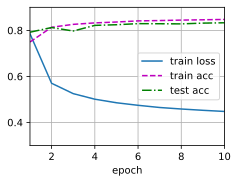

In [35]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

对图像进行分类预测

In [36]:
def predict_ch3(net, test_iter, n=6):  
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    # 将数字标签转为文本标签
    trues = d2l.get_fashion_mnist_labels(y)
    '''
    net(X)：模型预测，输出概率分布(batch_size, 10)
    .argmax(axis=1)：取每行最大概率的索引 → (batch_size,) 预测类别
    get_fashion_mnist_labels(...)：转为文本标签
    '''
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    # 将真实标签和预测标签组合成两行字符串
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    # 显示前 n 张图片及标题
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)),  # 取前n张并reshape为(n, 28, 28)
        1,  # 行数（1行）
        n,  # 列数（n列）
        titles=titles[0:n]) # 列数（n列）

predict_ch3(net, test_iter)